In [15]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

['kernel_linear_regression_toy' 'kernel_linear_regression_toy_basis_2'
 'kernel_linear_regression_toy_basis_4'
 'kernel_linear_regression_toy_basis_4_dim_1'
 'kernel_linear_regression_toy_basis_4_normalized'
 'kernel_linear_regression_toy_basis_4_normalized_x_scale_2'
 'kernel_linear_regression_toy_dim_20_basis_2'
 'kernel_linear_regression_toy_just_basis_4']
                                  run_id                      task  \
1      sanity-check-quadratic-regression  kernel_linear_regression   
3   low-dimension-joint-linear-quadratic  kernel_linear_regression   
2                 basis-4-not-normalized  kernel_linear_regression   
7   add3f196-62dd-4b87-9f5e-8d7ad29cf946  kernel_linear_regression   
6                     basis-4-normalized  kernel_linear_regression   
5           basis-4-normalized-x-scale-2  kernel_linear_regression   
0  high-dimension-joint-linear-quadratic  kernel_linear_regression   
4   a6c28d4b-4687-4631-9f46-1f5acbe1c18c  kernel_linear_regression   

       

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
1,sanity-check-quadratic-regression,kernel_linear_regression,Transformer,basis_dim=2,-1,-1,5,12,8,kernel_linear_regression_toy
3,low-dimension-joint-linear-quadratic,kernel_linear_regression,Transformer,basis_dim=2,-1,-1,5,12,8,kernel_linear_regression_toy_basis_2
2,basis-4-not-normalized,kernel_linear_regression,Transformer,basis_dim=4,-1,-1,5,12,8,kernel_linear_regression_toy_basis_4
7,add3f196-62dd-4b87-9f5e-8d7ad29cf946,kernel_linear_regression,Transformer,basis_dim=4,-1,-1,1,12,8,kernel_linear_regression_toy_basis_4_dim_1
6,basis-4-normalized,kernel_linear_regression,Transformer,basis_dim=4,-1,-1,5,12,8,kernel_linear_regression_toy_basis_4_normalized
5,basis-4-normalized-x-scale-2,kernel_linear_regression,Transformer,basis_dim=4,-1,-1,5,12,8,kernel_linear_regression_toy_basis_4_normalize...
0,high-dimension-joint-linear-quadratic,kernel_linear_regression,Transformer,basis_dim=2,-1,-1,20,12,8,kernel_linear_regression_toy_dim_20_basis_2
4,a6c28d4b-4687-4631-9f46-1f5acbe1c18c,kernel_linear_regression,Transformer,basis_dim=4,-1,-1,5,12,8,kernel_linear_regression_toy_just_basis_4


In [17]:
task = "kernel_linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "a6c28d4b-4687-4631-9f46-1f5acbe1c18c"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if True:
    metrics = get_run_metrics(run_path)  # these are normally precomputed at the end of training

{'standard': {'task_name': 'kernel_linear_regression', 'n_dims': 1, 'n_points': 41, 'batch_size': 64, 'data_name': 'gaussian', 'prompting_strategy': 'standard'}}


  0%|          | 0/1 [00:00<?, ?it/s]

TransformerModel(
  (_read_in): Linear(in_features=1, out_features=256, bias=True)
  (_backbone): GPT2Model(
    (wte): Embedding(50257, 256)
    (wpe): Embedding(82, 256)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout)

100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

kernel_linear_regression
{'basis_dim': 4}
{'standard': {'gpt2_embd=256_layer=12_head=8': {'mean': [57.81525421142578, 80.34271240234375, 38.45885467529297, 16.293794631958008, 11.274173736572266, 10.418390274047852, 138.7579803466797, 3.768115997314453, 2.5198709964752197, 1.5540510416030884, 3.5624194145202637, 1.7182804346084595, 3.156252384185791, 2.522731065750122, 2.886826276779175, 2.1259827613830566, 2.8197264671325684, 1.0994632244110107, 1.446869134902954, 2.3001081943511963, 1.791455864906311, 2.227404832839966, 3.119628667831421, 2.576158046722412, 1.533056616783142, 1.887041449546814, 2.705227851867676, 2.8557868003845215, 1.5624189376831055, 1.7774088382720947, 1.9678027629852295, 3.515937089920044, 4.050682544708252, 2.9322896003723145, 1.7966766357421875, 3.8015029430389404, 1.9788795709609985, 1.9712183475494385, 1.7862236499786377, 1.5788190364837646, 2.0758817195892334], 'std': [559.0265502929688, 801.586669921875, 388.0361328125, 228.72235107421875, 93.89878845214844

# Plot pre-computed metrics

kernel_linear_regression_toy_basis_4_dim_1 add3f196-62dd-4b87-9f5e-8d7ad29cf946
{'standard': {'task_name': 'kernel_linear_regression', 'n_dims': 1, 'n_points': 41, 'batch_size': 64, 'data_name': 'gaussian', 'prompting_strategy': 'standard'}}


100%|██████████| 1/1 [00:00<00:00, 55188.21it/s]

{'standard': {'gpt2_embd=256_layer=12_head=8': {'mean': [57.81525421142578, 80.34271240234375, 38.45885467529297, 16.293794631958008, 11.274173736572266, 10.418390274047852, 138.7579803466797, 3.768115997314453, 2.5198709964752197, 1.5540510416030884, 3.5624194145202637, 1.7182804346084595, 3.156252384185791, 2.522731065750122, 2.886826276779175, 2.1259827613830566, 2.8197264671325684, 1.0994632244110107, 1.446869134902954, 2.3001081943511963, 1.791455864906311, 2.227404832839966, 3.119628667831421, 2.576158046722412, 1.533056616783142, 1.887041449546814, 2.705227851867676, 2.8557868003845215, 1.5624189376831055, 1.7774088382720947, 1.9678027629852295, 3.515937089920044, 4.050682544708252, 2.9322896003723145, 1.7966766357421875, 3.8015029430389404, 1.9788795709609985, 1.9712183475494385, 1.7862236499786377, 1.5788190364837646, 2.0758817195892334], 'std': [559.0265502929688, 801.586669921875, 388.0361328125, 228.72235107421875, 93.89878845214844, 82.8450698852539, 4571.96533203125, 31.2

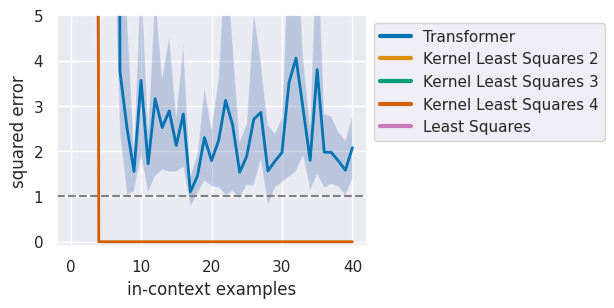

In [18]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
print(models)
print(metrics)
print(metrics)
print(conf)
basic_plot(metrics["standard"], models=models)
plt.show()

In [33]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [34]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [35]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [36]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [37]:
with torch.no_grad():
    pred = model(xs, ys)

5


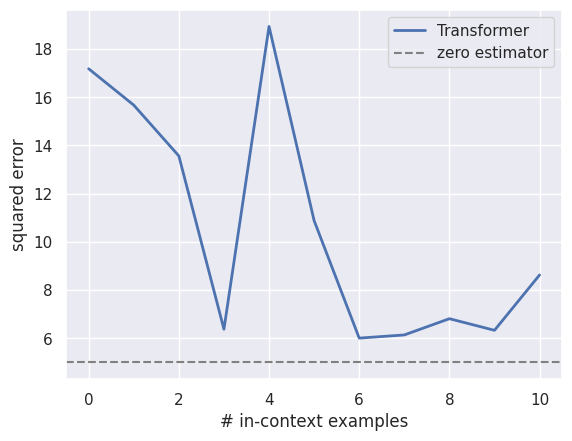

In [42]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "kernel_linear_regression": n_dims,
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]
plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [43]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

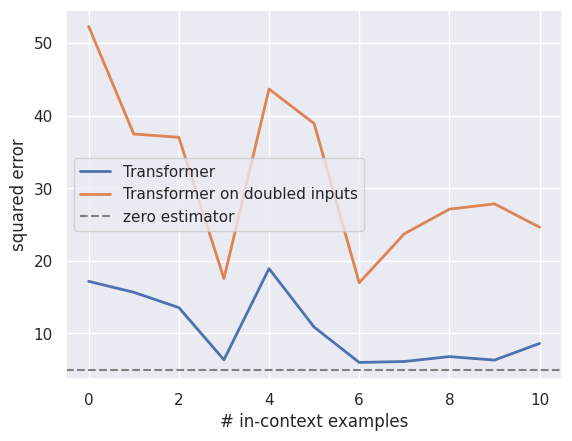

In [44]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.